# Installs and imports

In [1]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 34.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [1]:
!pip install xgboost=='1.6.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193.7 MB 34 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [3]:
import matplotlib
import xgboost
import catboost
print(matplotlib.__version__, " ", xgboost.__version__, " ", catboost.__version__)

3.1.3   1.6.0   1.1.1


In [4]:
import os
import pandas as pd
import numpy as np
import datetime
import json
import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

# Useful functions

## Plot feature importance

In [7]:
def plot_feature_importance(importance, names, model_type, figsize=(10, 5), n=20):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    abs_importance = np.abs(feature_importance)
    feature_names = []
    for name in names:
        feature_names.append(features_dict[name]['en'])
    feature_names = np.array(feature_names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names': feature_names,
          'feature_importance':feature_importance,
          'abs_importance': abs_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['abs_importance'], ascending=False, inplace=True)
    fi_df = fi_df.head(n)
    
    #Define size of bar plot
    plt.figure(figsize=figsize)
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.tick_params(labelsize=14)
    #plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')#, fontsize=14)
    plt.ylabel('FEATURE NAMES')#, fontsize=14)

## Pick XGBoost hyperparameters

In [9]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    # усреднение по трем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, X, y, cv=3).mean()
    print(current_score, params)
    return -current_score

## Find difference between feature presence and feature absence

In [10]:
def find_diff(model, client, feature):
    '''
    returns average of differences between model prediction
    with specified featrue set to 1
    and same model predictions for the same feature
    set to zero and set to nan
    '''
    client_ = client.copy()
    if feature == 'age': # numerical feature, has negative correlation with result
        return -1
    if feature == 'disability_group': # ordinal feature, has positive correlation with result
        return 1
    #client_[feature] = np.nan
    #with_nan = model.predict_proba(client_)[0, 1] # model prediction for nan case
    client_[feature] = 1
    with_one = model.predict_proba(client_)[0, 1] # model prediction for one case
    client_[feature] = 0
    with_zero = model.predict_proba(client_)[0, 1] # model prediction for zero case
    return (with_one - with_zero)

## Find both-ways most significant features for specific client

In [11]:
def find_important_features(model, client, n = 20, figsize=(12, 8)):
    '''
    returns top N most important features
    that are currently unknown (NaN)
    for specific client feature set
    '''
    unknown_features = client.columns[client.isna().any()].tolist()
    diffs = []
    for feature in unknown_features:
        diffs.append(find_diff(model, client, feature))
    data={'feature_names': unknown_features, 'feature_importance': diffs}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by='feature_importance', key=abs, ascending=False, inplace=True)
    fi_df = fi_df.head(n)
    
    #Define size of bar plot
    plt.figure(figsize=figsize)
    
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    #Add chart labels
    plt.tick_params(labelsize=12)
    plt.title('FEATURES TO CARE ABOUT')
    plt.xlabel('FEATURE IMPORTANCE')#, fontsize=14)
    plt.ylabel('FEATURE NAMES')#, fontsize=14)

## Get signs for feature importances

In [12]:
def get_signs (model, features):
    corrs = []
    result = []
    for feature in features:
        corr = xy_t.corr().contract_success[feature]
        corrs.append(corr)
    result = np.sign(corrs)
    return result

## Get and plot both-way feature importance (top N features)

In [13]:
def plot_icicle(model, features, fi_method_result):
    signed_importances = fi_method_result * get_signs(model, features)
    plot_feature_importance(signed_importances, features, "")

## Dictionary to make features readable

In [52]:
features_dict = {
    'type_1': {'ru': 'тип 1 Паспорт', 'en': 'type 1 Passport'},
    'type_2': {'ru': 'тип 2 Пенсия: оформление', 'en': 'type 2 Soc. benefits'},
    'type_3': {'ru': 'тип 3 Полис ОМС', 'en': 'type 3 Med. insurance'},
    'type_4': {'ru': 'тип 4 ИНН', 'en': 'type 4 Taxpayer ID'},
    'type_5': {'ru': 'тип 5 Трудовой стаж', 'en': 'type 5 Work experience'},
    'type_6': {'ru': 'тип 6 Инвалидность', 'en': 'type 6 Disability'},
    'type_7': {'ru': 'тип 7 Интернат', 'en': 'type 7 Nursinghome'},
    'type_8': {'ru': 'тип 8 Временная регистрация', 'en': 'type 8 Temp. registration'},
    'type_9': {'ru': 'тип 9 Регистрация по др. адресу', 'en': 'type 9 Registration at other address'},
    'type_10': {'ru': 'тип 10 Трудоустройство', 'en': 'type 10 Employment'},
    'type_11': {'ru': 'тип 11 Трудоустройство с проживанием', 'en': 'type 11 Employment with Accommodation'},
    'type_12': {'ru': 'тип 12 ДНП', 'en': 'type 12 Night Shelter'},
    'type_13': {'ru': 'тип 13 Реаб. центры алко/нарко', 'en': 'type 13 Rehab centers, alco/chem'},
    'type_14': {'ru': 'тип 14 Больница', 'en': 'type 14 Hospital'},
    'type_15': {'ru': 'тип 15 Поиск родственников', 'en': 'type 15 Relatives search'},
    'type_16': {'ru': 'тип 16 Возвращение в др. город', 'en': 'type 16 Return to other city'},
    'type_17': {'ru': 'тип 17 Гражданство', 'en': 'type 17 Citizenship'},
    'type_18': {'ru': 'тип 18 Юр. сопровождение в суде', 'en': 'type 18 Legal support in court'},
    'type_19': {'ru': 'тип 19 Жилье', 'en': 'type 19 Accommodation'},
    'type_20': {'ru': 'тип 20 Отмена мошеннической сделки, возврат жилья', 'en': 'type 20 Cancel fraudulent transaction, return housing'},
    'type_21': {'ru': 'тип 21 Запросы, заявления', 'en': 'type 21 Requests, aplications'},
    'type_22': {'ru': 'тип 22 Дом на полдороги', 'en': 'type 22 Halfway House project'},
    'type_23': {'ru': 'тип 23 Документы об образовании', 'en': 'type 23 Education documents'},
    'type_24': {'ru': 'тип 24 Свидетельство о рождении', 'en': 'type 24 Birth Certificate'},
    'type_25': {'ru': 'тип 25 Военный билет', 'en': 'type 25 Military Service Card'},
    'type_26': {'ru': 'тип 26 Загранпаспорт', 'en': 'type 26 Travel Passport'},
    'type_27': {'ru': 'тип 27 Тех. средства реабилитации', 'en': 'type 27 Technical rehabilitation equipment'},
    'type_28': {'ru': 'тип 28 СНИЛС', 'en': 'type 28 Individual Insurance Account Number'},
    'type_29': {'ru': 'тип 29 ЦСА', 'en': 'type 29 Social Adaptation Center'},
    'type_30': {'ru': 'тип 30 Проф. обучение', 'en': 'type 30 Proffessional Training'},
    'type_31': {'ru': 'тип 31 Установление личности', 'en': 'type 31 Identification'},
    'type_32': {'ru': 'тип 32 СПИД-центр: постановка на учет', 'en': 'type 32 AIDS center: registration'},
    'type_33': {'ru': 'тип 33 Кризисный центр', 'en': 'type 33 Crisis center'},
    'type_34': {'ru': 'тип 34 Психологическое сопровождение', 'en': 'type 34 Psychological support'},
    'type_35': {'ru': 'тип 35 Пенсия: перерасчет, возобновление', 'en': 'type 35 Soc. benefits: recalculation, renewal'},
    'type_36': {'ru': 'тип 36 Гражданский суд: доведение дела', 'en': 'type 36 Bringing case to Civil Court'},
    'type_37': {'ru': 'тип 37 Зарплата: получение', 'en': 'type 37 Payroll receipt'},
    'type_38': {'ru': 'тип 38 Восстановление здоровья', 'en': 'type 38 Health restoration'},
    'type_39': {'ru': 'тип 39 Адаптационная программа по трудоустройству', 'en': 'type 39 Empolyment Adaptation Program'},
    'type_40': {'ru': 'тип 40 Поддерживаемое проживание', 'en': 'type 40 Supported living'},
    'type_41': {'ru': 'тип 41 Сопровождение клиентов РП с химзависимостью', 'en': 'type 41 Support of clients with chem. addiction'},
    'type_42': {'ru': 'тип 42 Подготовка к заселению в ДНПД', 'en': 'type 42 Preparation for Halfway House accommodation'},
    'type_43': {'ru': 'тип 43 Хостел', 'en': 'type 43 Hostel'},
    'gender': {'ru': 'Мужской пол', 'en': 'Male'},
    'age': {'ru': 'Возраст', 'en': 'Age'},
    'no_birthdate': {'ru': 'Неизвестна дата рождения', 'en': 'Birthdate unknown'},
    'is_homeless': {'ru': 'Бездомный', 'en': 'Homeless'},
    'is_married': {'ru': 'Состоит в браке', 'en': 'Married'},
    'has_dependants': {'ru': 'Имеет родственников на попечении', 'en': 'Has dependants'},
    'has_profession': {'ru': 'Имеет профессию', 'en': 'Has profession'},
    'has_residence': {'ru': 'Имеет жилое помещение', 'en': 'Has residence'},
    'contacts_relatives': {'ru': 'Поддерживает контакты с родственниками', 'en': 'Contacts relatives'},
    'no_relatives': {'ru': 'Нет родственников', 'en': 'No relatives'},
    'source_perm_job': {'ru': 'Осн. источник средств - постоянная работа', 'en': 'Primary source of income is permanent job'},
    'source_temp_job': {'ru': 'Осн. источник средств - временная работа', 'en': 'Primary source of income is temporary job'},
    'source_alms': {'ru': 'Осн. источник средств - подаяния', 'en': 'Primary source of income is alms'},
    'source_relatives': {'ru': 'Осн. источник средств - поддержка родственниками', 'en': 'Primary source of income is support by relatives'},
    'source_other': {'ru': 'Осн. источник средств - прочее', 'en': 'Other primary source of income'},
    'source_gathering': {'ru': 'Осн. источник средств - собирательство', 'en': 'Primary source of income is gathering'},
    'source_charity': {'ru': 'Осн. источник средств - благотворительность', 'en': 'Primary source of income is charity'},
    'source_rehabs': {'ru': 'Осн. источник средств - реаб. центры', 'en': 'Primary source of income is rehab centers'},
    'source_social_benefits': {'ru': 'Осн. источник средств - пенсия', 'en': 'Primary source of income is social benefits'},
    'is_citizen': {'ru': 'Гражданин РФ', 'en': 'Has citizenship'},
    'is_retired': {'ru': 'Пенсионер', 'en': 'Retired'},
    'disability_group': {'ru': 'Группа инвалидности', 'en': 'Disability group'},
    'is_registered': {'ru': 'Есть регистрация', 'en': 'Registered'},
    'from_orphanage': {'ru': 'Выпускник детдома', 'en': 'From orphanage'},
    'was_confined': {'ru': 'Был в МЛС', 'en': 'Was confined'},
    'comments_alcohol': {'ru': 'Комментарии: проблемы с алкоголем', 'en': 'Comments: alcohol'},
    'comments_chem': {'ru': 'Комментарии: наркотики, химзависимость', 'en': 'Comments: narco or chemical addiction'},
    'comments_disability': {'ru': 'Комментарии: инвалидность', 'en': 'Comments: disability'},
    'comments_absence': {'ru': 'Комментарии: неявка', 'en': 'Comments: absence'},
    'comments_orphange': {'ru': 'Комментарии: детдом', 'en': 'Comments: orphanage'},
    'comments_work': {'ru': 'Комментарии: поиски работы', 'en': 'Comments: looking for job'},
    'comments_confinement': {'ru': 'Комментарии: МЛС', 'en': 'Comments: confinement'},
    'comments_noresidence': {'ru': 'Комментарии: отсутствие жилья', 'en': 'Comments: no residence'},
    'comments_aggression': {'ru': 'Комментарии: агрессивное поведение', 'en': 'Comments: aggressive behavior'},
    'comments_disturbance': {'ru': 'Комментарии: нарушение режима', 'en': 'Comments: disturbance'},
    'comments_disease': {'ru': 'Комментарии: болезнь', 'en': 'Comments disease'},
    'comments_death': {'ru': 'Комментарии: смерть клиента или близких', 'en': 'Comments: client\'s or relative\'s death'},
    'comments_nursinghome': {'ru': 'Комментарии: интернат', 'en': 'Comments: nursinghome'},
    'comments_relatives': {'ru': 'Комментарии: родственники', 'en': 'Comments: relatives'},
    'comments_illiteracy': {'ru': 'Комментарии: неграмотность', 'en': 'Comments: illiteracy'},
    'comments_foreigner': {'ru': 'Комментарии: иностранный гражданин', 'en': 'Comments: foreign citizen'},
    'comments_ticket': {'ru': 'Комментарии: нужен билет', 'en': 'Comments: ticket needed'},
    'comments_court': {'ru': 'Комментарии: судебное разбирательство', 'en': 'Comments: court'},
    'comments_pregnancy': {'ru': 'Комментарии: беременность', 'en': 'Comments: pregnancy'},
    'comments_mental': {'ru': 'Комментарии: проблемы с психикой', 'en': 'Comments: mental problems'},
    'comments_fire': {'ru': 'Комментарии: сгоревшее жилье', 'en': 'Comments: fire in residence'},
    'comments_social_benefits': {'ru': 'Комментарии: пенсия', 'en': 'Comments: social benefits'},
    'comments_divorce': {'ru': 'Комментарии: развод', 'en': 'Comments: divorce'},
    'released_recently': {'ru': 'Недавно освободился из МЛС', 'en': 'Comments: released recently'},
    'chem_confirmed': {'ru': 'Хим. завимость подтверждена', 'en': 'Chem. addiction confirmed'},
    'chem_possible': {'ru': 'Хим. зависимость возможна', 'en': 'Chem. addiction possible'},
    'chem_noanswer': {'ru': 'Хим зависимость - отказ от ответа', 'en': 'Chem. addicition - refused to answer'},
    'chem_no': {'ru': 'Хим. зависимость отрицает', 'en': 'Denies chem. addiction'}
}

# Data download

In [132]:
with_onehot_types = pd.read_csv('final_with_onehot_types_ALL_221120.csv')
with_onehot_types.columns

Index(['contract_id', 'client_id', 'gender', 'age', 'no_birthdate',
       'is_homeless', 'is_married', 'has_dependants', 'has_profession',
       'has_residence', 'contract_status_id', 'contract_success',
       'comments_alcohol', 'comments_chem', 'comments_disability',
       'comments_absence', 'comments_orphange', 'comments_work',
       'comments_confinement', 'comments_noresidence', 'comments_aggression',
       'comments_disturbance', 'comments_disease', 'comments_death',
       'comments_nursinghome', 'comments_relatives', 'comments_illiteracy',
       'comments_foreigner', 'comments_ticket', 'comments_court',
       'comments_pregnancy', 'comments_mental', 'comments_fire',
       'comments_social_benefits', 'comments_divorce', 'contacts_relatives',
       'no_relatives', 'source_perm_job', 'source_temp_job',
       'source_social_benefits', 'source_alms', 'source_relatives',
       'source_other', 'source_gathering', 'source_charity', 'source_rehabs',
       'is_citizen', 'is

In [16]:
with_onehot_types.head()

,contract_id,client_id,gender,age,no_birthdate,is_homeless,is_married,has_dependants,has_profession,has_residence,...,type_34,type_35,type_36,type_37,type_38,type_39,type_40,type_41,type_42,type_43
0,583,1,1,59.067606,0,1,1.0,1.0,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
1,207,3,1,60.535124,0,1,0.0,1.0,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
2,22,9,1,74.399885,0,1,0.0,0.0,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1067,10,1,82.764191,0,1,0.0,1.0,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1067,10,1,82.764191,0,1,0.0,1.0,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0


subset is what experiments in the paper were made at: unsuccessful results are only those directly related to client's behavour.

In [25]:
subset = with_onehot_types[with_onehot_types.contract_status_id.isin([2, 3, 5, 7, 8])]
subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6349 entries, 0 to 8530
Data columns (total 100 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   contract_id               6349 non-null   int64  
 1   client_id                 6349 non-null   int64  
 2   gender                    6349 non-null   int64  
 3   age                       6347 non-null   float64
 4   no_birthdate              6349 non-null   int64  
 5   is_homeless               6349 non-null   int64  
 6   is_married                5528 non-null   float64
 7   has_dependants            5516 non-null   float64
 8   has_profession            2086 non-null   float64
 9   has_residence             5443 non-null   float64
 10  contract_status_id        6349 non-null   int64  
 11  contract_success          6349 non-null   int64  
 12  comments_alcohol          6093 non-null   float64
 13  comments_chem             6093 non-null   float64
 14  comment

# ML

## Test and validation sets

In [27]:
x_columns_t = list(set(subset.columns) - set(['contract_id', 'client_id', 'contract_success', 'contract_status_id']))
xy_columns_t = x_columns_t + ['contract_success']
X_t = subset[x_columns_t]
y_t = subset.contract_success
xy_t = subset[xy_columns_t]

In [28]:
X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(X_t,
                                                          y_t,
                                                          test_size=0.2,
                                                          random_state=SEED,
                                                          stratify=y_t)
X_train_t.shape, X_val_t.shape, y_train_t.shape, y_val_t.shape

((5079, 96), (1270, 96), (5079,), (1270,))

In [29]:
rus = RandomUnderSampler(random_state=SEED)
X_res_train_t, y_res_train_t = rus.fit_resample(X_train_t, y_train_t)
X_res_train_t.shape, y_res_train_t.shape

((3568, 96), (3568,))

In [30]:
ros = RandomOverSampler(random_state=SEED)
X_ros_train_t, y_ros_train_t = ros.fit_resample(X_train_t, y_train_t)
X_ros_train_t.shape, y_ros_train_t.shape

((6590, 96), (6590,))

## Process NaNs for models that don't eat NaNs

Columns with NaNs

In [31]:
nan_columns = X_t.columns[X_t.isna().any()].tolist()
nan_columns

['comments_noresidence',
 'is_married',
 'source_perm_job',
 'comments_disease',
 'comments_work',
 'comments_relatives',
 'comments_disability',
 'chem_confirmed',
 'source_relatives',
 'comments_aggression',
 'source_gathering',
 'comments_mental',
 'comments_confinement',
 'comments_ticket',
 'contacts_relatives',
 'source_social_benefits',
 'comments_divorce',
 'comments_fire',
 'source_charity',
 'source_other',
 'comments_social_benefits',
 'chem_noanswer',
 'is_citizen',
 'comments_absence',
 'comments_illiteracy',
 'released_recently',
 'has_dependants',
 'was_confined',
 'comments_foreigner',
 'comments_chem',
 'comments_pregnancy',
 'comments_alcohol',
 'source_rehabs',
 'chem_no',
 'is_registered',
 'source_alms',
 'has_profession',
 'no_relatives',
 'disability_group',
 'age',
 'comments_death',
 'chem_possible',
 'is_retired',
 'from_orphanage',
 'has_residence',
 'comments_orphange',
 'comments_disturbance',
 'comments_nursinghome',
 'comments_court',
 'source_temp_job']

Pick columns where it is feasible to regard NaN as zero. All comment columns are such, for example.

In [32]:
zero_columns = ['comments_pregnancy',
 'comments_ticket',
 'comments_disturbance',
 'comments_disease',
 'comments_divorce',
 'comments_illiteracy',
 'comments_fire',
 'comments_disability',
 'comments_foreigner',
 'comments_mental',
 'comments_chem',
 'comments_absence',
 'comments_aggression',
 'comments_noresidence',
 'comments_death',
 'comments_relatives',
 'comments_alcohol',
 'comments_orphange',
 'comments_court',
 'comments_confinement',
 'comments_nursinghome',
 'comments_work',
 'comments_social_benefits',
 'source_temp_job',
 'source_relatives',
 'source_charity',
 'source_other',
 'source_alms',
 'source_gathering',
 'source_perm_job',
 'source_rehabs',
 'chem_noanswer',
 'chem_confirmed',
 'chem_no',
 'chem_possible',
 'disability_group']

In [33]:
rest = list(set(nan_columns) - set(zero_columns))
rest

['has_residence',
 'source_social_benefits',
 'is_citizen',
 'age',
 'is_married',
 'released_recently',
 'no_relatives',
 'has_dependants',
 'contacts_relatives',
 'is_registered',
 'is_retired',
 'has_profession',
 'from_orphanage',
 'was_confined']

Looks like only age is a logical candidate to average. But we have already seen that values like -1 do not work well. Let's regard "don't know" as average("yes", "no") and see what happens.

In [34]:
X_zero = X_t[zero_columns].fillna(0)
X_zero

,comments_pregnancy,comments_ticket,comments_disturbance,comments_disease,comments_divorce,comments_illiteracy,comments_fire,comments_disability,comments_foreigner,comments_mental,...,source_other,source_alms,source_gathering,source_perm_job,source_rehabs,chem_noanswer,chem_confirmed,chem_no,chem_possible,disability_group
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8527,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
X_mean = X_t[rest].fillna(X_t[rest].mean())
X_mean

,has_residence,source_social_benefits,is_citizen,age,is_married,released_recently,no_relatives,has_dependants,contacts_relatives,is_registered,is_retired,has_profession,from_orphanage,was_confined
0,0.000000,0.09236,0.926672,59.067606,1.000000,1.0,0.000000,1.000000,1.000000,0.329201,0.184373,0.845638,0.122163,0.381811
1,0.000000,0.09236,0.926672,60.535124,0.000000,1.0,0.000000,1.000000,0.000000,0.329201,0.184373,0.845638,0.122163,0.381811
3,0.000000,0.09236,0.926672,82.764191,0.000000,1.0,0.000000,1.000000,0.000000,0.329201,0.184373,0.845638,0.122163,0.381811
4,0.000000,0.09236,0.926672,82.764191,0.000000,1.0,0.000000,1.000000,0.000000,0.329201,0.184373,0.845638,0.122163,0.381811
5,0.000000,0.09236,0.926672,82.764191,0.000000,1.0,0.000000,1.000000,0.000000,0.329201,0.184373,0.845638,0.122163,0.381811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8523,0.000000,0.00000,1.000000,42.815390,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
8527,0.000000,0.00000,1.000000,36.704381,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
8528,1.000000,0.09236,1.000000,69.167745,0.089182,1.0,0.215833,0.146302,0.315124,0.329201,0.184373,0.845638,0.122163,0.381811
8529,0.360279,0.09236,0.926672,49.761005,0.089182,1.0,0.215833,0.146302,0.315124,0.329201,0.184373,0.845638,0.122163,0.381811


In [36]:
X_nonans = X_t.copy()
X_nonans[zero_columns] = X_zero[zero_columns]
X_nonans[rest] = X_mean[rest]
X_nonans.isna().sum().sum()

0

In [49]:
X_nonans.columns

Index(['type_3', 'comments_noresidence', 'is_married', 'source_perm_job',
       'type_7', 'comments_disease', 'type_13', 'type_26', 'type_42',
       'type_10', 'comments_work', 'type_8', 'comments_relatives',
       'comments_disability', 'chem_confirmed', 'no_birthdate',
       'source_relatives', 'comments_aggression', 'type_4', 'type_24',
       'type_18', 'source_gathering', 'comments_mental',
       'comments_confinement', 'type_34', 'type_32', 'comments_ticket',
       'contacts_relatives', 'type_35', 'type_39', 'source_social_benefits',
       'comments_divorce', 'comments_fire', 'source_charity', 'type_23',
       'source_other', 'comments_social_benefits', 'chem_noanswer',
       'is_homeless', 'type_29', 'gender', 'is_citizen', 'comments_absence',
       'type_38', 'comments_illiteracy', 'type_27', 'released_recently',
       'type_36', 'type_19', 'type_22', 'has_dependants', 'type_20', 'type_30',
       'was_confined', 'type_37', 'type_2', 'type_40', 'type_31',
       'com

In [37]:
X_nonans.shape

(6349, 96)

Now normalize it.

In [38]:
sc = StandardScaler()
X_std = sc.fit_transform(X_nonans)

In [39]:
X_train_std, X_val_std, y_train_std, y_val_std = train_test_split(X_std,
                                                                  y_t,
                                                                  test_size=0.2,
                                                                  random_state=SEED,
                                                                  stratify=y_t)
X_train_std.shape, X_val_std.shape, y_train_std.shape, y_val_std.shape

((5079, 96), (1270, 96), (5079,), (1270,))

In [40]:
rus = RandomUnderSampler(random_state=SEED)
X_res_train_std, y_res_train_std = rus.fit_resample(X_train_std, y_train_std)
X_res_train_std.shape, y_res_train_std.shape

((3568, 96), (3568,))

In [41]:
ros = RandomOverSampler(random_state=SEED)
X_ros_train_std, y_ros_train_std = ros.fit_resample(X_train_std, y_train_std)
X_ros_train_std.shape, y_ros_train_std.shape

((6590, 96), (6590,))

In [42]:
y_val_t.value_counts()

1    824
0    446
Name: contract_success, dtype: int64

## Baseline: Logistic Regression

In [43]:
lr_under = LogisticRegression(random_state=SEED)
lr_under.fit(X_res_train_std, y_res_train_std)
lr_over = LogisticRegression(random_state=SEED)
lr_over.fit(X_ros_train_std, y_ros_train_std)

LogisticRegression(random_state=42)

MSE = 0.3653543307086614
Accuracy = 0.6346456692913386
Precision = 0.6274271844660194
Recall = 0.7670623145400594
F1 Score = 0.6902536715620828
              precision    recall  f1-score   support

unsuccessful       0.48      0.65      0.55       446
  successful       0.77      0.63      0.69       824

    accuracy                           0.63      1270
   macro avg       0.63      0.64      0.62      1270
weighted avg       0.67      0.63      0.64      1270



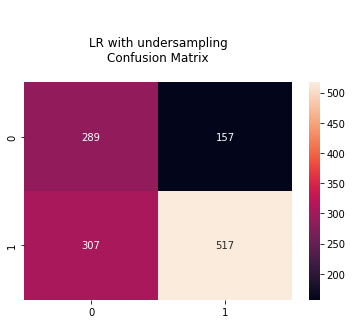

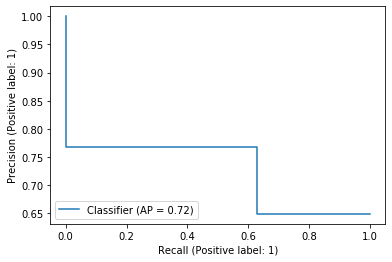

In [44]:
lr_under_pred = lr_under.predict(X_val_std)
print('MSE =', mean_squared_error(lr_under_pred, y_val_t))
print('Accuracy =',accuracy_score(lr_under_pred, y_val_t))
print('Precision =', precision_score(lr_under_pred, y_val_t))
print('Recall =', recall_score(lr_under_pred, y_val_t))
print('F1 Score =', f1_score(lr_under_pred, y_val_t))

print(classification_report(y_val_t, lr_under_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, lr_under_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nLR with undersampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, lr_under_pred)

MSE = 0.36299212598425196
Accuracy = 0.637007874015748
Precision = 0.6274271844660194
Recall = 0.7704918032786885
F1 Score = 0.691638795986622
              precision    recall  f1-score   support

unsuccessful       0.49      0.65      0.56       446
  successful       0.77      0.63      0.69       824

    accuracy                           0.64      1270
   macro avg       0.63      0.64      0.63      1270
weighted avg       0.67      0.64      0.65      1270



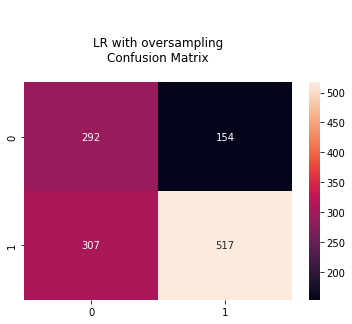

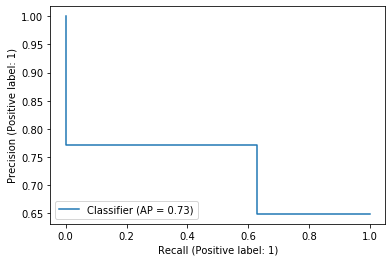

In [45]:
lr_over_pred = lr_over.predict(X_val_std)
print('MSE =', mean_squared_error(lr_over_pred, y_val_t))
print('Accuracy =',accuracy_score(lr_over_pred, y_val_t))
print('Precision =', precision_score(lr_over_pred, y_val_t))
print('Recall =', recall_score(lr_over_pred, y_val_t))
print('F1 Score =', f1_score(lr_over_pred, y_val_t))

print(classification_report(y_val_t, lr_over_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, lr_over_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nLR with oversampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, lr_over_pred)

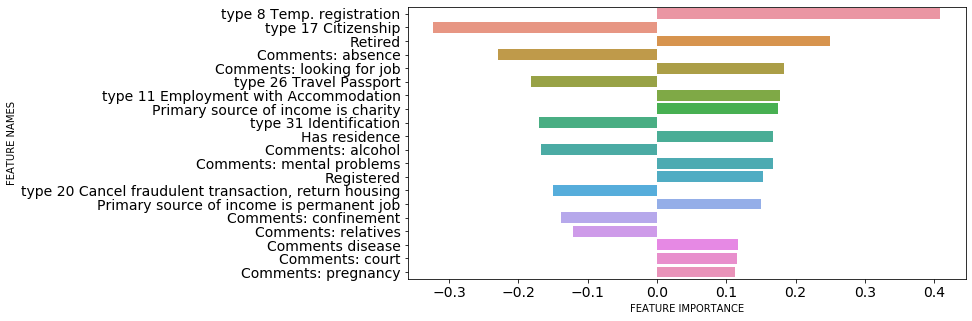

In [53]:
plot_feature_importance(lr_under.coef_[0], x_columns_t, 'Logistic Regression with undersampling ')

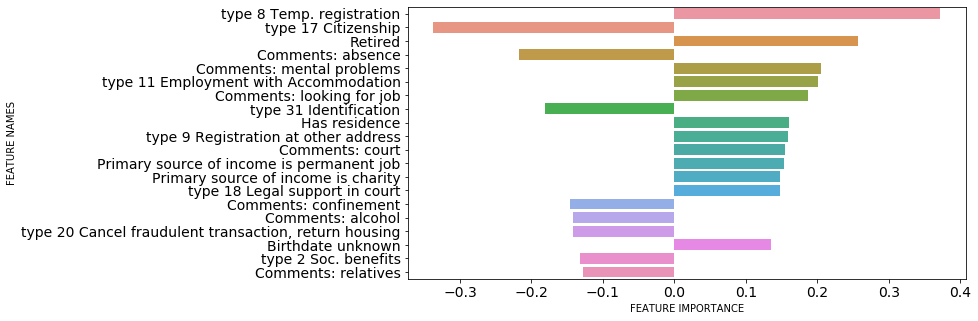

In [54]:
plot_feature_importance(lr_over.coef_[0], x_columns_t, 'Logistic Regression with oversampling ')

## Support Vector Machine

In [55]:
svm_under = SVC(kernel = 'linear', random_state=SEED)
svm_over = SVC(kernel = 'linear', random_state=SEED)

(we first try everything with default parameters, but linear kernel is needed here since otherwise we would not be able to get coeffs for feature importance)

In [56]:
svm_under.fit(X_res_train_std, y_res_train_std)
svm_over.fit(X_ros_train_std, y_ros_train_std)

SVC(kernel='linear', random_state=42)

MSE = 0.36220472440944884
Accuracy = 0.6377952755905512
Precision = 0.6310679611650486
Recall = 0.7692307692307693
F1 Score = 0.6933333333333334
              precision    recall  f1-score   support

unsuccessful       0.49      0.65      0.56       446
  successful       0.77      0.63      0.69       824

    accuracy                           0.64      1270
   macro avg       0.63      0.64      0.63      1270
weighted avg       0.67      0.64      0.65      1270



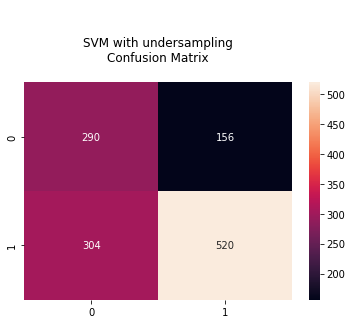

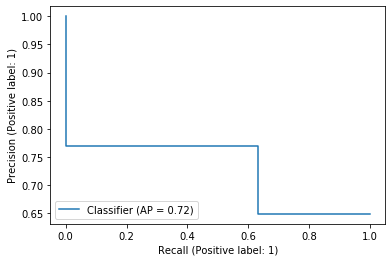

In [57]:
svm_under_pred = svm_under.predict(X_val_std)
print('MSE =', mean_squared_error(svm_under_pred, y_val_t))
print('Accuracy =',accuracy_score(svm_under_pred, y_val_t))
print('Precision =', precision_score(svm_under_pred, y_val_t))
print('Recall =', recall_score(svm_under_pred, y_val_t))
print('F1 Score =', f1_score(svm_under_pred, y_val_t))

print(classification_report(y_val_t, svm_under_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, svm_under_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nSVM with undersampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, svm_under_pred)

MSE = 0.36850393700787404
Accuracy = 0.631496062992126
Precision = 0.5983009708737864
Recall = 0.7825396825396825
F1 Score = 0.6781292984869326
              precision    recall  f1-score   support

unsuccessful       0.48      0.69      0.57       446
  successful       0.78      0.60      0.68       824

    accuracy                           0.63      1270
   macro avg       0.63      0.65      0.62      1270
weighted avg       0.68      0.63      0.64      1270



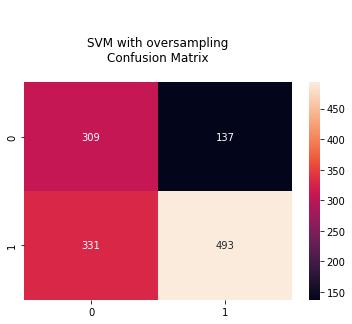

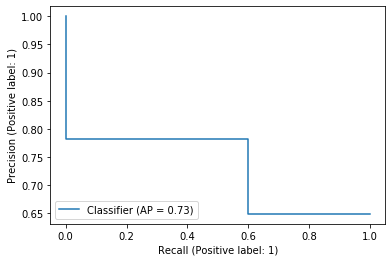

In [58]:
svm_over_pred = svm_over.predict(X_val_std)
print('MSE =', mean_squared_error(svm_over_pred, y_val_t))
print('Accuracy =',accuracy_score(svm_over_pred, y_val_t))
print('Precision =', precision_score(svm_over_pred, y_val_t))
print('Recall =', recall_score(svm_over_pred, y_val_t))
print('F1 Score =', f1_score(svm_over_pred, y_val_t))

print(classification_report(y_val_t, svm_over_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, svm_over_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nSVM with oversampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, svm_over_pred)

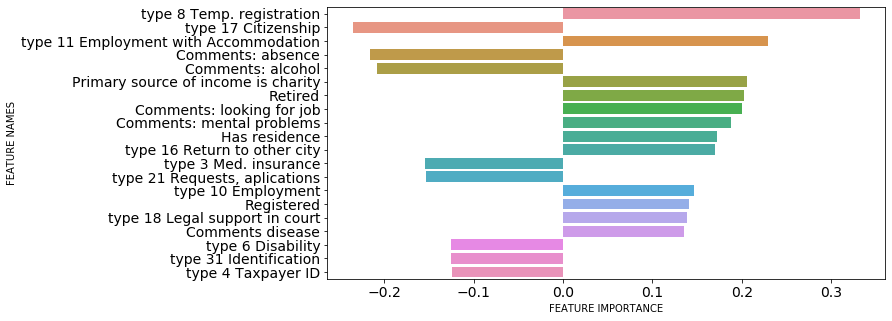

In [59]:
plot_feature_importance(svm_under.coef_[0], x_columns_t, 'Support Vector Machine with undersampling ')

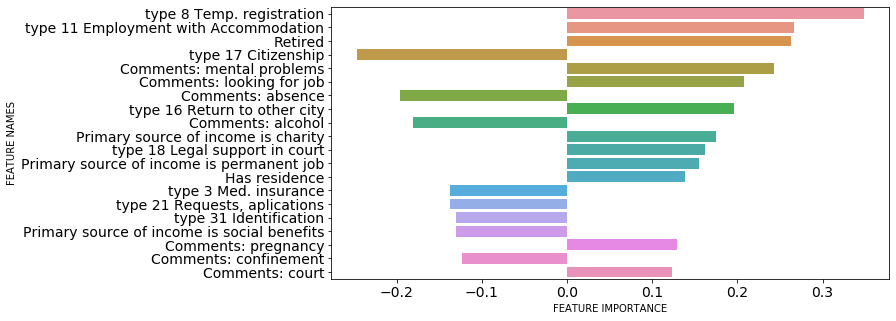

In [60]:
plot_feature_importance(svm_over.coef_[0], x_columns_t, 'Support Vector Machine with oversampling ')

## Decision Tree Classifier

In [61]:
dt_under = DecisionTreeClassifier(random_state=SEED)
dt_over = DecisionTreeClassifier(random_state=SEED)

In [62]:
dt_under.fit(X_res_train_std, y_res_train_std)
dt_over.fit(X_ros_train_std, y_ros_train_std)

DecisionTreeClassifier(random_state=42)

MSE = 0.2740157480314961
Accuracy = 0.7259842519685039
Precision = 0.7293689320388349
Recall = 0.8278236914600551
F1 Score = 0.7754838709677419
              precision    recall  f1-score   support

unsuccessful       0.59      0.72      0.65       446
  successful       0.83      0.73      0.78       824

    accuracy                           0.73      1270
   macro avg       0.71      0.72      0.71      1270
weighted avg       0.74      0.73      0.73      1270



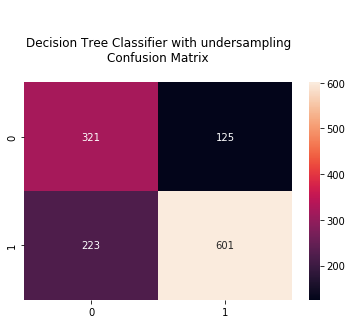

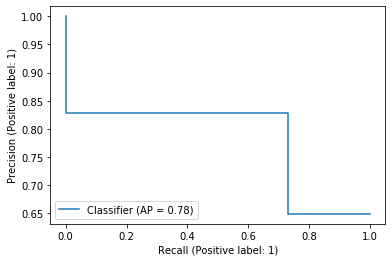

In [63]:
dt_under_pred = dt_under.predict(X_val_std)
print('MSE =', mean_squared_error(dt_under_pred, y_val_t))
print('Accuracy =',accuracy_score(dt_under_pred, y_val_t))
print('Precision =', precision_score(dt_under_pred, y_val_t))
print('Recall =', recall_score(dt_under_pred, y_val_t))
print('F1 Score =', f1_score(dt_under_pred, y_val_t))

print(classification_report(y_val_t, dt_under_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, dt_under_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nDecision Tree Classifier with undersampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, dt_under_pred)

MSE = 0.2346456692913386
Accuracy = 0.7653543307086614
Precision = 0.7851941747572816
Recall = 0.8424479166666666
F1 Score = 0.8128140703517589
              precision    recall  f1-score   support

unsuccessful       0.65      0.73      0.69       446
  successful       0.84      0.79      0.81       824

    accuracy                           0.77      1270
   macro avg       0.74      0.76      0.75      1270
weighted avg       0.77      0.77      0.77      1270



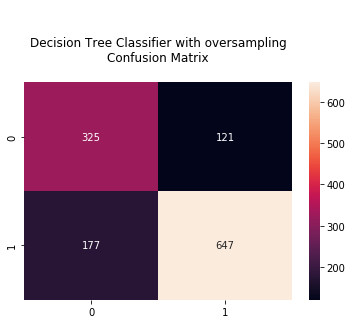

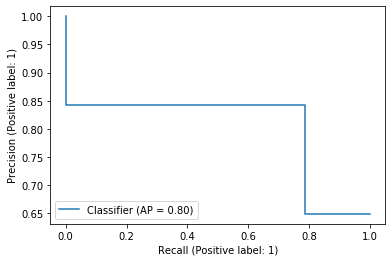

In [64]:
dt_over_pred = dt_over.predict(X_val_std)
print('MSE =', mean_squared_error(dt_over_pred, y_val_t))
print('Accuracy =',accuracy_score(dt_over_pred, y_val_t))
print('Precision =', precision_score(dt_over_pred, y_val_t))
print('Recall =', recall_score(dt_over_pred, y_val_t))
print('F1 Score =', f1_score(dt_over_pred, y_val_t))

print(classification_report(y_val_t, dt_over_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, dt_over_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nDecision Tree Classifier with oversampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, dt_over_pred)

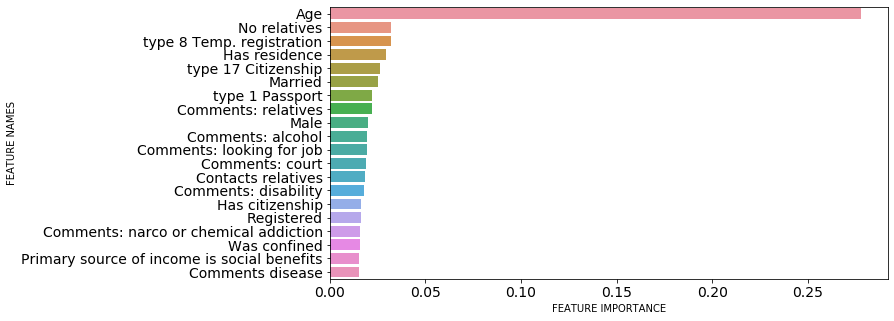

In [65]:
plot_feature_importance(dt_under.feature_importances_, x_columns_t, 'Decision Tree Classifier with undersampling ')

In [66]:
get_signs(dt_over, x_columns_t)

array([-1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,
        1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.,
        1., -1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,
        1.,  1.,  1., -1.,  1.,  1.,  1., nan,  1., -1.,  1., -1., -1.,
        1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
       -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1., -1.,  1., -1.,
       -1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1., nan,  1.,  1., -1.,
        1.,  1.,  1., -1.,  1.])

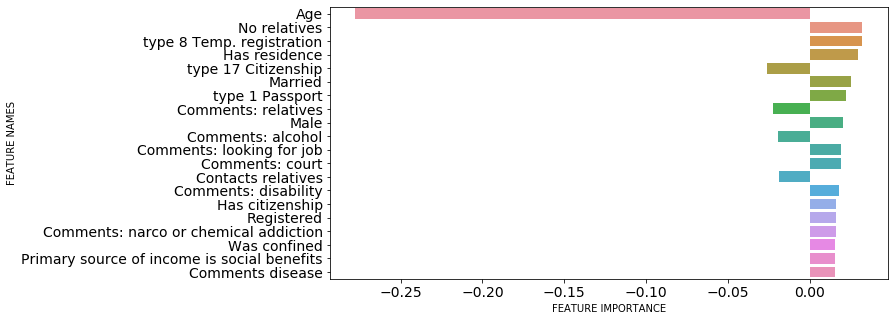

In [68]:
plot_icicle(dt_under, x_columns_t, dt_under.feature_importances_)

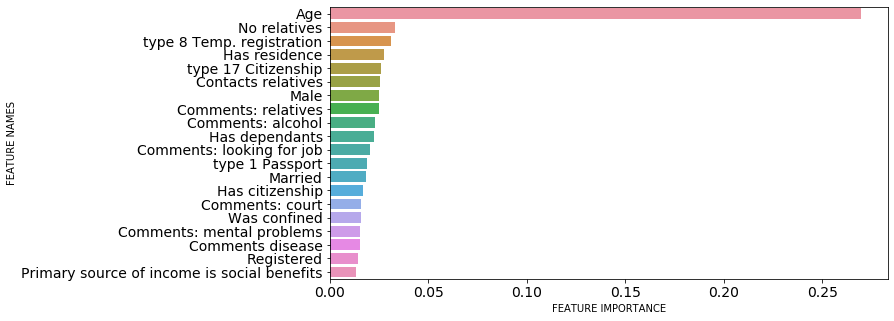

In [69]:
plot_feature_importance(dt_over.feature_importances_, x_columns_t, 'Decision Tree Classifier with oversampling ')

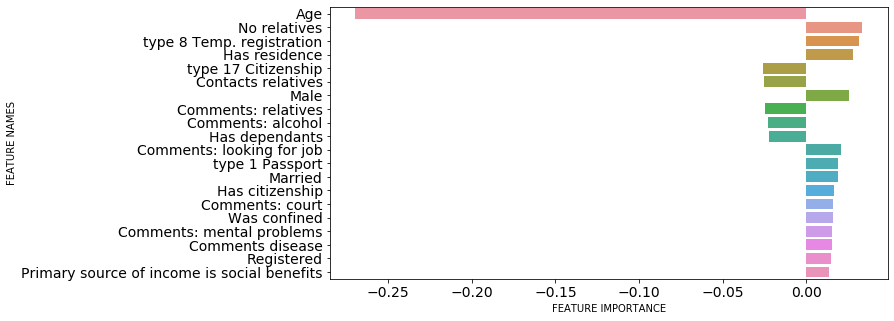

In [70]:
plot_icicle(dt_over, x_columns_t, dt_over.feature_importances_)

## k Nearest Neighbors

In [71]:
knn_under = KNeighborsClassifier()
knn_over = KNeighborsClassifier()

In [72]:
knn_under.fit(X_res_train_std, y_res_train_std)
knn_over.fit(X_ros_train_std, y_ros_train_std)

KNeighborsClassifier()

MSE = 0.3637795275590551
Accuracy = 0.6362204724409449
Precision = 0.6140776699029126
Recall = 0.7784615384615384
F1 Score = 0.6865671641791045
              precision    recall  f1-score   support

unsuccessful       0.49      0.68      0.57       446
  successful       0.78      0.61      0.69       824

    accuracy                           0.64      1270
   macro avg       0.63      0.65      0.63      1270
weighted avg       0.68      0.64      0.64      1270



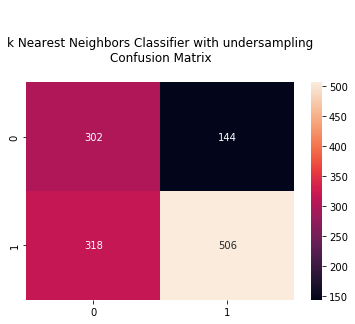

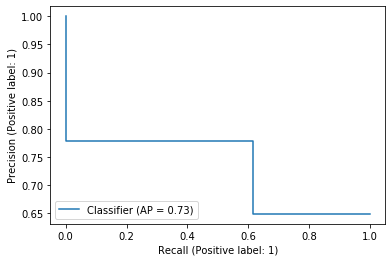

In [73]:
knn_under_pred = knn_under.predict(X_val_std)
print('MSE =', mean_squared_error(knn_under_pred, y_val_t))
print('Accuracy =',accuracy_score(knn_under_pred, y_val_t))
print('Precision =', precision_score(knn_under_pred, y_val_t))
print('Recall =', recall_score(knn_under_pred, y_val_t))
print('F1 Score =', f1_score(knn_under_pred, y_val_t))

print(classification_report(y_val_t, knn_under_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, knn_under_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nk Nearest Neighbors Classifier with undersampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, knn_under_pred)

MSE = 0.3551181102362205
Accuracy = 0.6448818897637796
Precision = 0.6371359223300971
Recall = 0.7754800590841949
F1 Score = 0.6995336442371751
              precision    recall  f1-score   support

unsuccessful       0.50      0.66      0.57       446
  successful       0.78      0.64      0.70       824

    accuracy                           0.64      1270
   macro avg       0.64      0.65      0.63      1270
weighted avg       0.68      0.64      0.65      1270



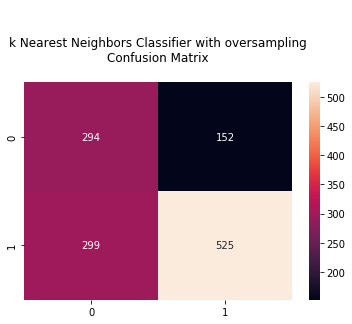

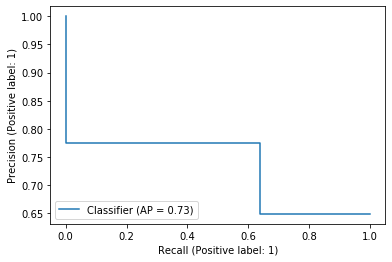

In [74]:
knn_over_pred = knn_over.predict(X_val_std)
print('MSE =', mean_squared_error(knn_over_pred, y_val_t))
print('Accuracy =',accuracy_score(knn_over_pred, y_val_t))
print('Precision =', precision_score(knn_over_pred, y_val_t))
print('Recall =', recall_score(knn_over_pred, y_val_t))
print('F1 Score =', f1_score(knn_over_pred, y_val_t))

print(classification_report(y_val_t, knn_over_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, knn_over_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nk Nearest Neighbors Classifier with oversampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, knn_over_pred)

It apperars that there is no quick and easy way to derive feature importances for kNeighborsClassifier. We will later derive them for all models in unified way, to prevernt variance caused by differences in nature of models.

## Random Forest

In [75]:
rf_under = RandomForestClassifier(random_state=SEED)
rf_over = RandomForestClassifier(random_state=SEED)

In [76]:
rf_under.fit(X_res_train_std, y_res_train_std)
rf_over.fit(X_ros_train_std, y_ros_train_std)

RandomForestClassifier(random_state=42)

MSE = 0.22755905511811023
Accuracy = 0.7724409448818897
Precision = 0.75
Recall = 0.8815977175463623
F1 Score = 0.8104918032786885
              precision    recall  f1-score   support

unsuccessful       0.64      0.81      0.72       446
  successful       0.88      0.75      0.81       824

    accuracy                           0.77      1270
   macro avg       0.76      0.78      0.76      1270
weighted avg       0.80      0.77      0.78      1270



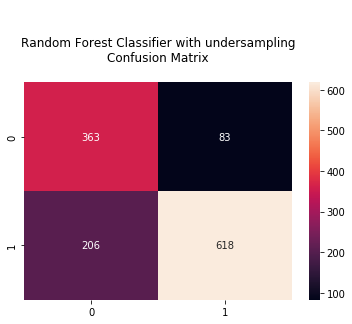

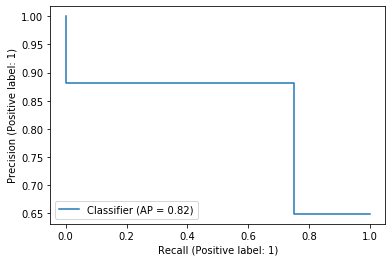

In [77]:
rf_under_pred = rf_under.predict(X_val_std)
print('MSE =', mean_squared_error(rf_under_pred, y_val_t))
print('Accuracy =',accuracy_score(rf_under_pred, y_val_t))
print('Precision =', precision_score(rf_under_pred, y_val_t))
print('Recall =', recall_score(rf_under_pred, y_val_t))
print('F1 Score =', f1_score(rf_under_pred, y_val_t))

print(classification_report(y_val_t, rf_under_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, rf_under_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nRandom Forest Classifier with undersampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, rf_under_pred)

MSE = 0.18818897637795276
Accuracy = 0.8118110236220473
Precision = 0.8519417475728155
Recall = 0.8571428571428571
F1 Score = 0.8545343883140596
              precision    recall  f1-score   support

unsuccessful       0.73      0.74      0.73       446
  successful       0.86      0.85      0.85       824

    accuracy                           0.81      1270
   macro avg       0.79      0.79      0.79      1270
weighted avg       0.81      0.81      0.81      1270



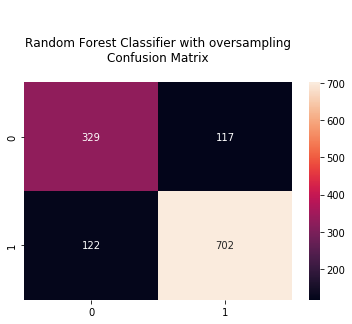

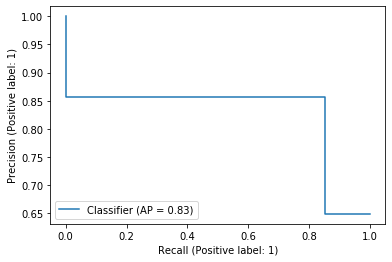

In [78]:
rf_over_pred = rf_over.predict(X_val_std)
print('MSE =', mean_squared_error(rf_over_pred, y_val_t))
print('Accuracy =',accuracy_score(rf_over_pred, y_val_t))
print('Precision =', precision_score(rf_over_pred, y_val_t))
print('Recall =', recall_score(rf_over_pred, y_val_t))
print('F1 Score =', f1_score(rf_over_pred, y_val_t))

print(classification_report(y_val_t, rf_over_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, rf_over_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nRandom Forest Classifier with oversampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, rf_over_pred)

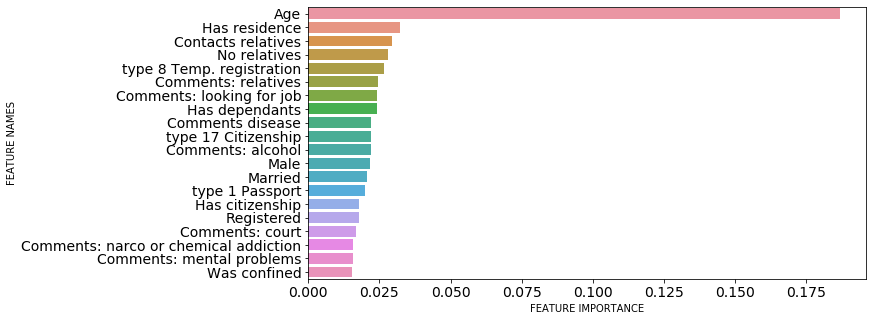

In [79]:
plot_feature_importance(rf_under.feature_importances_, x_columns_t, 'Random Forest Classifier with undersampling ')

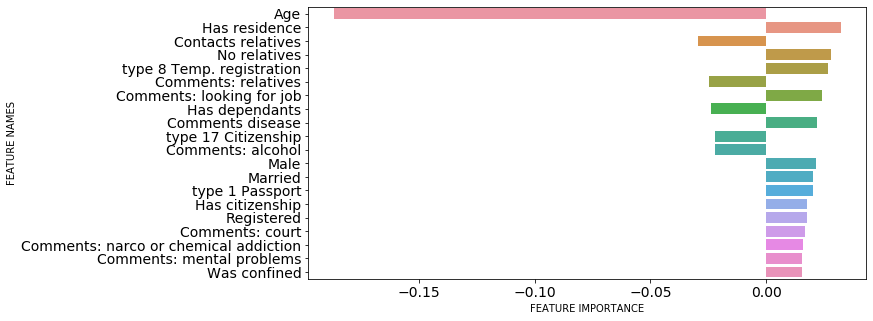

In [80]:
plot_icicle(rf_under, x_columns_t, rf_under.feature_importances_)

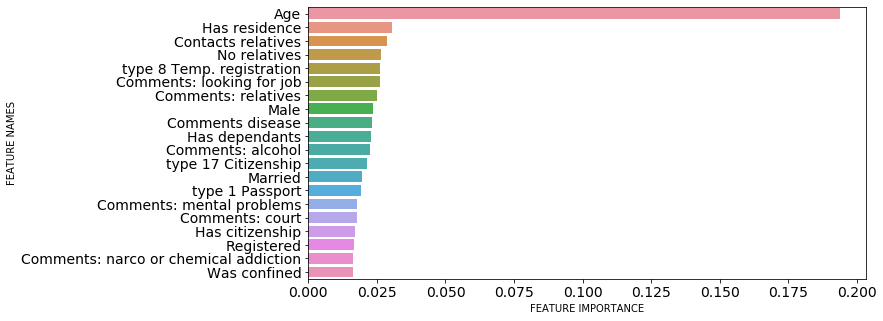

In [81]:
plot_feature_importance(rf_over.feature_importances_, x_columns_t, 'Random Forest Classifier with oversampling ')

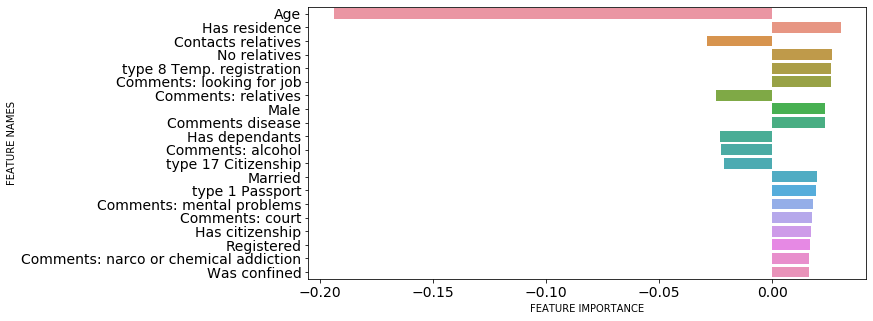

In [82]:
plot_icicle(rf_over, x_columns_t, rf_over.feature_importances_)

## Fully Connected Neural Network

In [83]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [84]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data_under = TrainData(torch.FloatTensor(X_res_train_std), 
                             torch.FloatTensor(y_res_train_std))
train_data_over = TrainData(torch.FloatTensor(X_ros_train_std), 
                            torch.FloatTensor(y_ros_train_std))

In [85]:
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

val_data = TestData(torch.FloatTensor(X_val_std))

In [86]:
train_loader_under = DataLoader(dataset=train_data_under, batch_size=BATCH_SIZE, shuffle=True)
train_loader_over = DataLoader(dataset=train_data_over, batch_size=BATCH_SIZE, shuffle=True)

In [87]:
test_loader = DataLoader(dataset=val_data, batch_size=1)

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [89]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [90]:
size_1 = 1024
size_2 = 512
size_3 = 256
dropout_rate = 0.2

In [91]:
class BinaryClassification(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassification, self).__init__()
        # Number of input features
        self.layer_1 = nn.Linear(input_size, size_1) 
        self.layer_2 = nn.Linear(size_1, size_2)
        self.layer_3 = nn.Linear(size_2, size_3)
        self.layer_out = nn.Linear(size_3, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.batchnorm1 = nn.BatchNorm1d(size_1)
        self.batchnorm2 = nn.BatchNorm1d(size_2)
        self.batchnorm3 = nn.BatchNorm1d(size_3)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [92]:
model = BinaryClassification(X_train_std.shape[1])
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=96, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=256, bias=True)
  (layer_out): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [93]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader_under:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader_under):.5f} | Acc: {epoch_acc/len(train_loader_under):.3f}')

Epoch 001: | Loss: 0.66400 | Acc: 63.732
Epoch 002: | Loss: 0.57088 | Acc: 70.161
Epoch 003: | Loss: 0.52036 | Acc: 74.411
Epoch 004: | Loss: 0.47497 | Acc: 77.536
Epoch 005: | Loss: 0.44772 | Acc: 78.143
Epoch 006: | Loss: 0.42236 | Acc: 79.911
Epoch 007: | Loss: 0.39234 | Acc: 81.857
Epoch 008: | Loss: 0.36280 | Acc: 83.161
Epoch 009: | Loss: 0.35467 | Acc: 83.929
Epoch 010: | Loss: 0.32887 | Acc: 85.143
Epoch 011: | Loss: 0.29276 | Acc: 87.268
Epoch 012: | Loss: 0.28754 | Acc: 88.000
Epoch 013: | Loss: 0.28355 | Acc: 87.286
Epoch 014: | Loss: 0.27538 | Acc: 87.607
Epoch 015: | Loss: 0.26249 | Acc: 87.804
Epoch 016: | Loss: 0.25921 | Acc: 88.250
Epoch 017: | Loss: 0.24705 | Acc: 89.018
Epoch 018: | Loss: 0.22379 | Acc: 90.018
Epoch 019: | Loss: 0.22487 | Acc: 90.446
Epoch 020: | Loss: 0.23068 | Acc: 89.929
Epoch 021: | Loss: 0.22342 | Acc: 90.179
Epoch 022: | Loss: 0.22037 | Acc: 90.286
Epoch 023: | Loss: 0.20495 | Acc: 90.661
Epoch 024: | Loss: 0.19187 | Acc: 91.268
Epoch 025: | Los

In [94]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [95]:
print(classification_report(y_val_t, y_pred_list, target_names=['unsuccessful', 'successful']))

              precision    recall  f1-score   support

unsuccessful       0.54      0.70      0.61       446
  successful       0.81      0.67      0.73       824

    accuracy                           0.68      1270
   macro avg       0.67      0.69      0.67      1270
weighted avg       0.71      0.68      0.69      1270



Text(0.5, 1, '\n\nFCNN with undersampling\nConfusion Matrix\n')

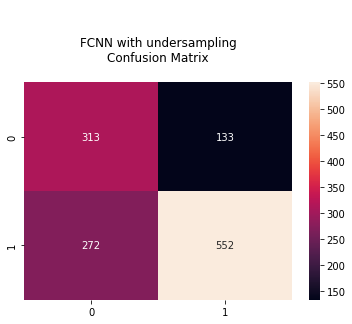

In [96]:
cm = confusion_matrix(y_val_t, y_pred_list)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nFCNN with undersampling\nConfusion Matrix\n')

In [97]:
model_over = BinaryClassification(X_train_std.shape[1])
model_over.to(device)
print(model_over)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_over.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=96, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=256, bias=True)
  (layer_out): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [98]:
model_over.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader_over:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model_over(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader_over):.5f} | Acc: {epoch_acc/len(train_loader_over):.3f}')

Epoch 001: | Loss: 0.63176 | Acc: 65.660
Epoch 002: | Loss: 0.53523 | Acc: 73.320
Epoch 003: | Loss: 0.47330 | Acc: 77.485
Epoch 004: | Loss: 0.42840 | Acc: 79.913
Epoch 005: | Loss: 0.39872 | Acc: 81.583
Epoch 006: | Loss: 0.36228 | Acc: 84.078
Epoch 007: | Loss: 0.33541 | Acc: 84.864
Epoch 008: | Loss: 0.32430 | Acc: 85.709
Epoch 009: | Loss: 0.29890 | Acc: 87.049
Epoch 010: | Loss: 0.28695 | Acc: 87.845
Epoch 011: | Loss: 0.26936 | Acc: 88.252
Epoch 012: | Loss: 0.25920 | Acc: 88.777
Epoch 013: | Loss: 0.24491 | Acc: 89.786
Epoch 014: | Loss: 0.24583 | Acc: 89.728
Epoch 015: | Loss: 0.22787 | Acc: 90.184
Epoch 016: | Loss: 0.20944 | Acc: 91.049
Epoch 017: | Loss: 0.21868 | Acc: 90.612
Epoch 018: | Loss: 0.20827 | Acc: 90.961
Epoch 019: | Loss: 0.20323 | Acc: 91.204
Epoch 020: | Loss: 0.20093 | Acc: 91.398
Epoch 021: | Loss: 0.19798 | Acc: 91.388
Epoch 022: | Loss: 0.18492 | Acc: 92.184
Epoch 023: | Loss: 0.18511 | Acc: 91.825
Epoch 024: | Loss: 0.16525 | Acc: 92.650
Epoch 025: | Los

In [99]:
y_pred_list_over = []
model_over.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model_over(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list_over.append(y_pred_tag.cpu().numpy())

y_pred_list_over = [a.squeeze().tolist() for a in y_pred_list_over]

In [100]:
print(classification_report(y_val_t, y_pred_list_over, target_names=['unsuccessful', 'successful']))

              precision    recall  f1-score   support

unsuccessful       0.63      0.63      0.63       446
  successful       0.80      0.80      0.80       824

    accuracy                           0.74      1270
   macro avg       0.72      0.72      0.72      1270
weighted avg       0.74      0.74      0.74      1270



Text(0.5, 1, '\n\nFCNN with oversampling\nConfusion Matrix\n')

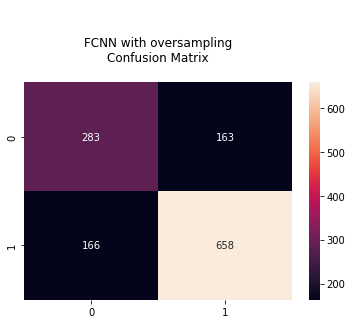

In [101]:
cm = confusion_matrix(y_val_t, y_pred_list_over)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nFCNN with oversampling\nConfusion Matrix\n')

## XGBoost

### From file

There is a problem with loading saved model: the feature names get shuffled (had to ask at stackoverflow to find that out).

Therefore, extracting feature names from loaded model, and shuffling them back in the validation set is needed.

Works fine with joblib, and for some (still unknown) reason does not work with native load_model method, so we leave only joblib here.

In [ ]:
xgb = joblib.load('xgb_rm_CORRECTED.model')
xgb_ros = joblib.load('xgb_ros_CORRECTED.model')

In [ ]:
features_under = xgb.get_booster().feature_names
features_over = xgb_ros.get_booster().feature_names

In [ ]:
print(len(features_over))

93


In [ ]:
X_val_t_under = X_val_t[features_under]
X_val_t_over = X_val_t[features_over]

MSE = 0.2
Accuracy = 0.8
Precision = 0.7803398058252428
Recall = 0.8980446927374302
F1 Score = 0.8350649350649351
              precision    recall  f1-score   support

unsuccessful       0.67      0.84      0.75       446
  successful       0.90      0.78      0.84       824

    accuracy                           0.80      1270
   macro avg       0.79      0.81      0.79      1270
weighted avg       0.82      0.80      0.80      1270



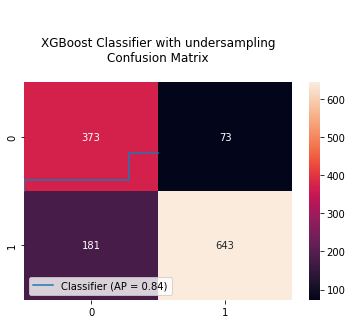

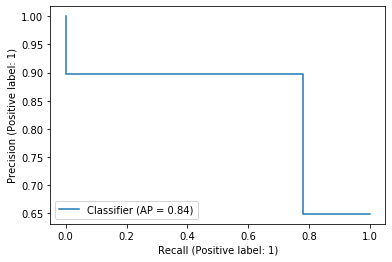

In [ ]:
xgb_pred = xgb.predict(X_val_t_under)
print('MSE =', mean_squared_error(xgb_pred, y_val_t))
print('Accuracy =',accuracy_score(xgb_pred, y_val_t))
print('Precision =', precision_score(xgb_pred, y_val_t))
print('Recall =', recall_score(xgb_pred, y_val_t))
print('F1 Score =', f1_score(xgb_pred, y_val_t))
PrecisionRecallDisplay.from_predictions(y_val_t, xgb_pred)

print(classification_report(y_val_t, xgb_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, xgb_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nXGBoost Classifier with undersampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, xgb_pred)

MSE = 0.15433070866141732
Accuracy = 0.8456692913385827
Precision = 0.8810679611650486
Recall = 0.8810679611650486
F1 Score = 0.8810679611650486
              precision    recall  f1-score   support

unsuccessful       0.78      0.78      0.78       446
  successful       0.88      0.88      0.88       824

    accuracy                           0.85      1270
   macro avg       0.83      0.83      0.83      1270
weighted avg       0.85      0.85      0.85      1270



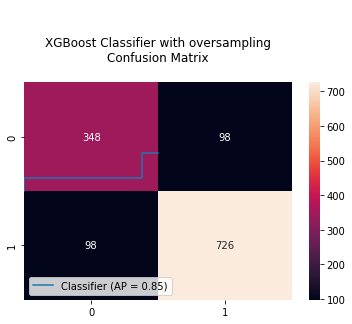

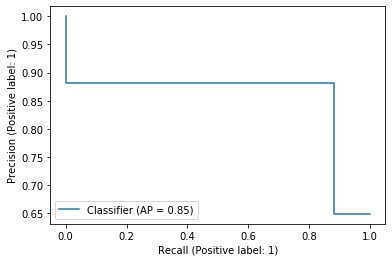

In [ ]:
xgb_ros_pred = xgb_ros.predict(X_val_t_over)
print('MSE =', mean_squared_error(xgb_ros_pred, y_val_t))
print('Accuracy =',accuracy_score(xgb_ros_pred, y_val_t))
print('Precision =', precision_score(xgb_ros_pred, y_val_t))
print('Recall =', recall_score(xgb_ros_pred, y_val_t))
print('F1 Score =', f1_score(xgb_ros_pred, y_val_t))
PrecisionRecallDisplay.from_predictions(y_val_t, xgb_ros_pred)

print(classification_report(y_val_t, xgb_ros_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, xgb_ros_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nXGBoost Classifier with oversampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, xgb_ros_pred)

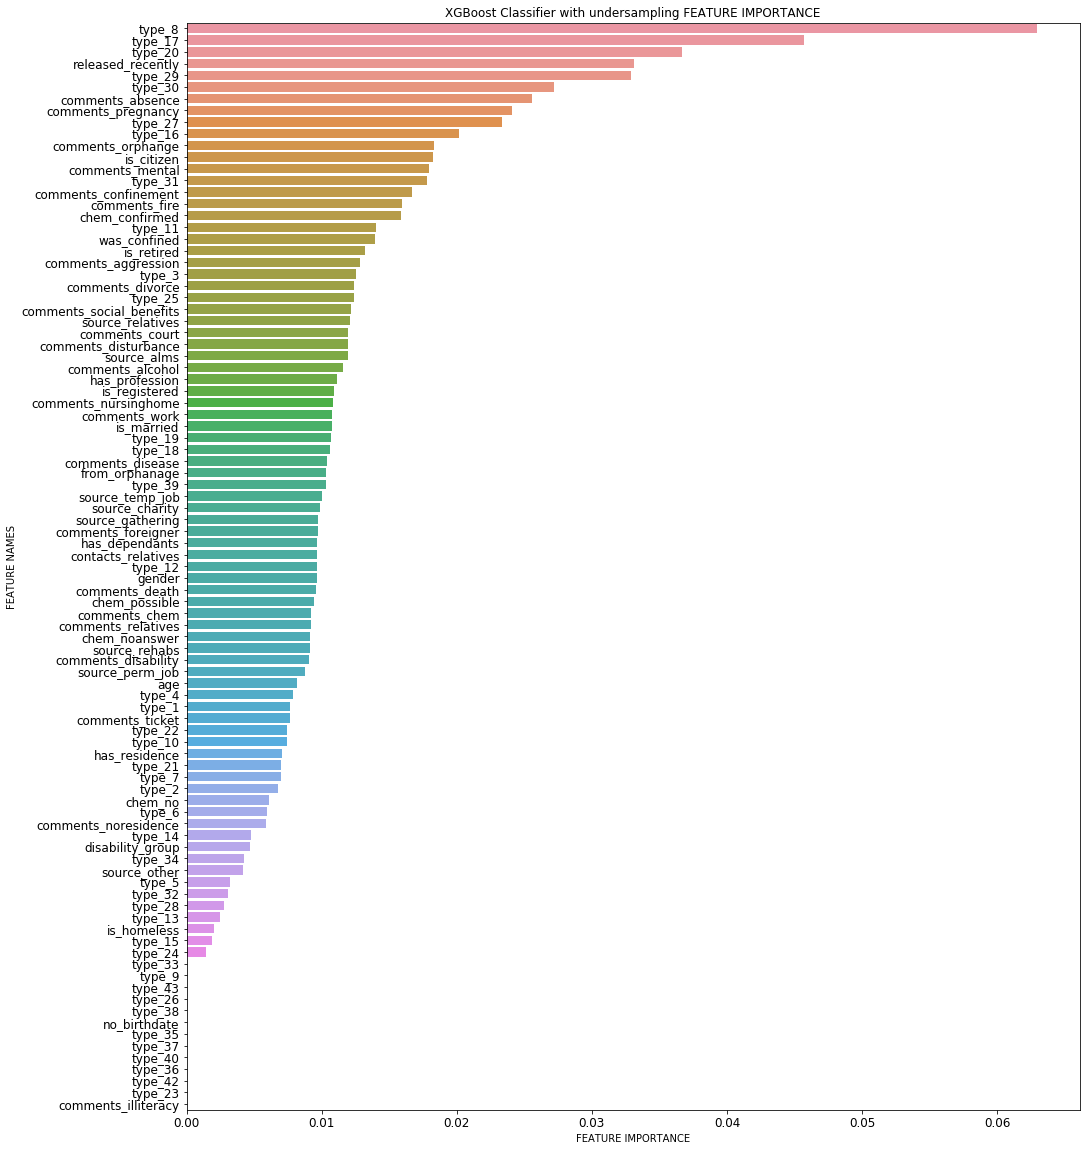

In [ ]:
plot_feature_importance(xgb.feature_importances_, features_under, 'XGBoost Classifier with undersampling ')

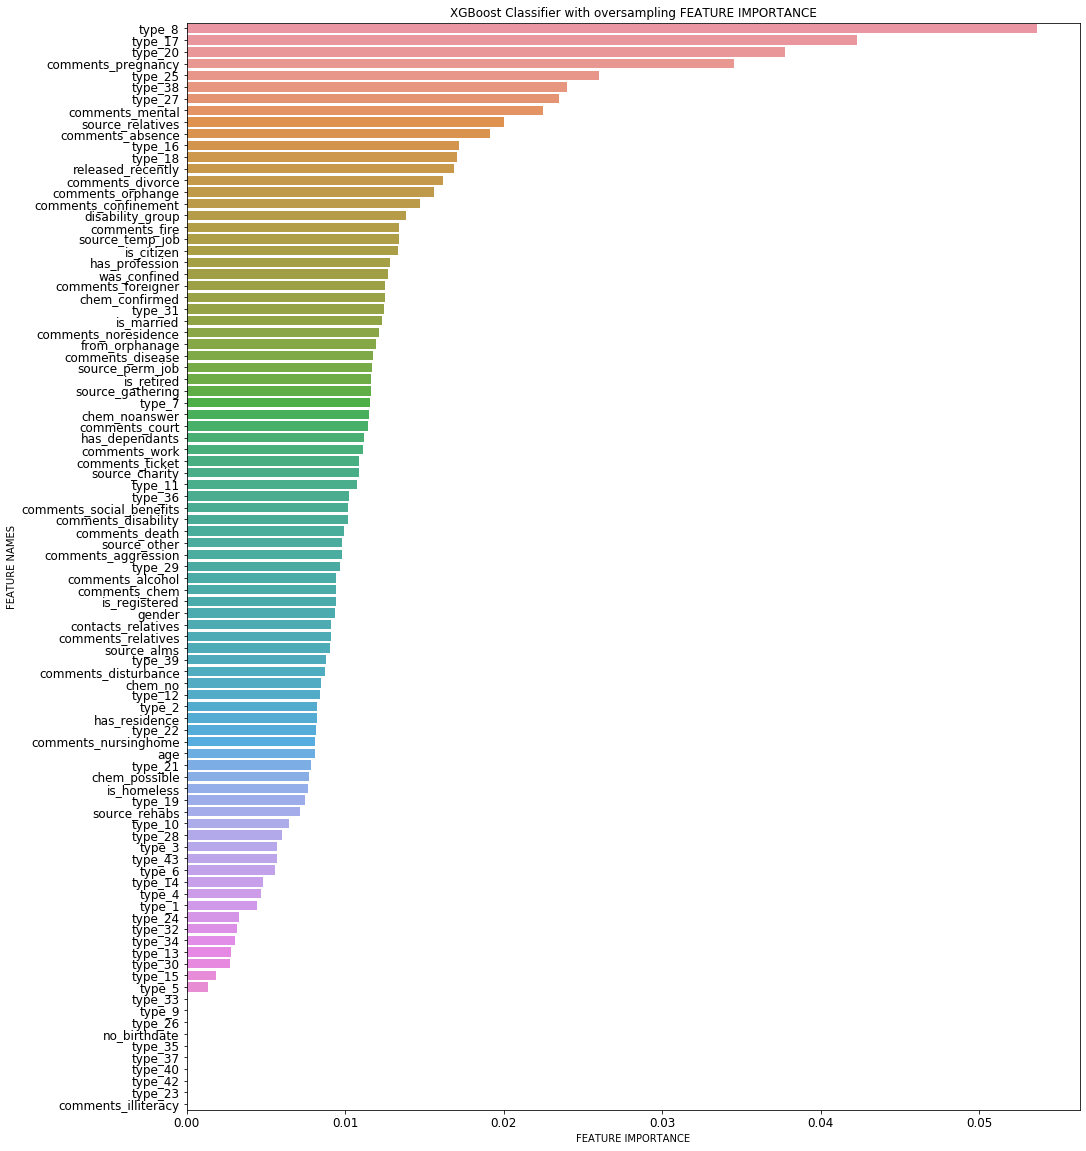

In [ ]:
plot_feature_importance(xgb_ros.feature_importances_, features_over, 'XGBoost Classifier with oversampling ')

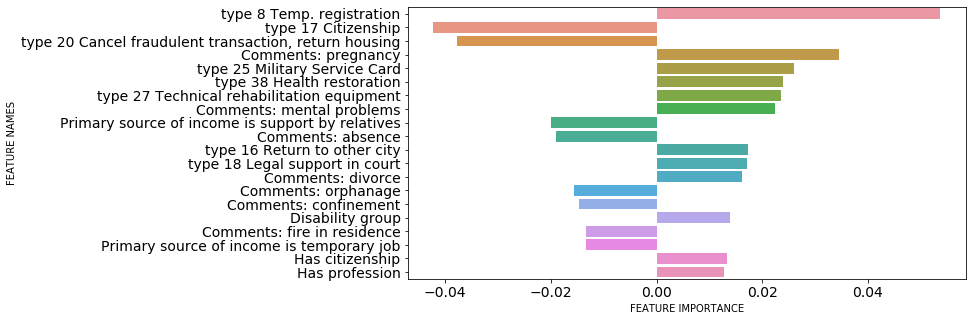

In [ ]:
plot_icicle(xgb_ros, features_over, xgb_ros.feature_importances_)

If results from file are fine, skip the next subsection.

### If results from file are not reproducible, re-train model and update file.

In [102]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    # average over 3 folds
    current_score = cross_val_score(clf, X, y, cv=3).mean()
    print(current_score, params)
    return -current_score

In [103]:
X = X_res_train_t
y = y_res_train_t
 
 
simple_space_xgb = {
            'n_estimators': hp.choice('n_estimators', range(100, 900)),
            'eta': hp.quniform('eta', 0.01, 0.5, 0.01),
            'max_depth':  hp.choice('max_depth', np.arange(1, 20, dtype=int)),
}
 
best = fmin(fn=hyperopt_xgb_score, space=simple_space_xgb, algo=tpe.suggest, max_evals=20)
print('best:')
print(best)

0.7654088717067987
{'eta': 0.17, 'max_depth': 9, 'n_estimators': 182}
0.7637298485416034
{'eta': 0.11, 'max_depth': 6, 'n_estimators': 557}
0.7676518883415436
{'eta': 0.28, 'max_depth': 6, 'n_estimators': 173}
0.7774612283937965
{'eta': 0.41000000000000003, 'max_depth': 18, 'n_estimators': 492}
0.7735377750763889
{'eta': 0.45, 'max_depth': 14, 'n_estimators': 359}
0.7480360352719725
{'eta': 0.24, 'max_depth': 3, 'n_estimators': 464}
0.7547599022788258
{'eta': 0.07, 'max_depth': 10, 'n_estimators': 145}
0.7427073100055833
{'eta': 0.12, 'max_depth': 7, 'n_estimators': 122}
0.6583488231289151
{'eta': 0.3, 'max_depth': 1, 'n_estimators': 245}
0.7791423718351934
{'eta': 0.47000000000000003, 'max_depth': 14, 'n_estimators': 786}
0.7469111109540537
{'eta': 0.1, 'max_depth': 6, 'n_estimators': 199}
0.7766197143281198
{'eta': 0.24, 'max_depth': 14, 'n_estimators': 709}
0.7724154422071604
{'eta': 0.21, 'max_depth': 13, 'n_estimators': 321}
0.675448143933772
{'eta': 0.47000000000000003, 'max_dept

In [104]:
ros_best_params = {'eta': 0.34, 'max_depth': 9, 'n_estimators': 853}
#ros_best_params = {'eta': 0.37, 'max_depth': 16, 'n_estimators': 653}
best_params = {'eta': 0.47, 'max_depth': 13, 'n_estimators': 686}
#best_params = {'eta': 0.26, 'max_depth': 11, 'n_estimators': 441}
#best_params = {'eta': 0.21, 'max_depth': 11, 'n_estimators': 825}
#best_params = {'eta': 0.25, 'max_depth': 14, 'n_estimators': 585}# 81 80 81 371 656 1027
#best_params = {'eta': 0.21, 'max_depth': 11, 'n_estimators': 835}# 81 80 81 375 652 1027

In [105]:
xgb = XGBClassifier(**best_params, random_state=SEED, tree_method='exact')
xgb.fit(X_res_train_t, y_res_train_t)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.47,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.469999999, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=13, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=686,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, ...)

In [106]:
xgb_ros = XGBClassifier(**ros_best_params, random_state=SEED, tree_method='exact')
xgb_ros.fit(X_ros_train_t, y_ros_train_t)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.34,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.340000004, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=853,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, ...)

MSE = 0.20078740157480315
Accuracy = 0.7992125984251969
Precision = 0.7742718446601942
Recall = 0.9024045261669024
F1 Score = 0.8334421946440235


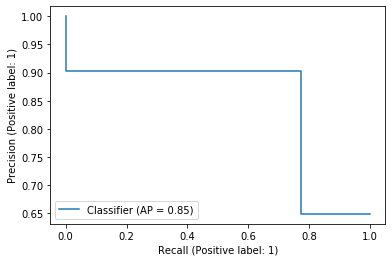

In [107]:
xgb_pred = xgb.predict(X_val_t)
print('MSE =', mean_squared_error(xgb_pred, y_val_t))
print('Accuracy =',accuracy_score(xgb_pred, y_val_t))
print('Precision =', precision_score(xgb_pred, y_val_t))
print('Recall =', recall_score(xgb_pred, y_val_t))
print('F1 Score =', f1_score(xgb_pred, y_val_t))
PrecisionRecallDisplay.from_predictions(y_val_t, xgb_pred)

MSE = 0.16141732283464566
Accuracy = 0.8385826771653543
Precision = 0.866504854368932
Recall = 0.8825710754017305
F1 Score = 0.8744641763625228


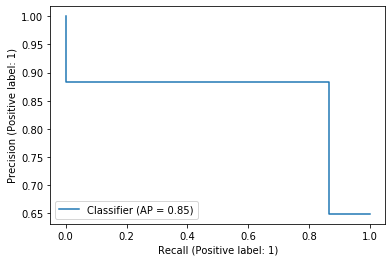

In [108]:
xgb_ros_pred = xgb_ros.predict(X_val_t)
print('MSE =', mean_squared_error(xgb_ros_pred, y_val_t))
print('Accuracy =',accuracy_score(xgb_ros_pred, y_val_t))
print('Precision =', precision_score(xgb_ros_pred, y_val_t))
print('Recall =', recall_score(xgb_ros_pred, y_val_t))
print('F1 Score =', f1_score(xgb_ros_pred, y_val_t))
PrecisionRecallDisplay.from_predictions(y_val_t, xgb_ros_pred)

In [109]:
print(classification_report(y_val_t, xgb_pred, target_names=['unsuccessful', 'successful']))

              precision    recall  f1-score   support

unsuccessful       0.67      0.85      0.75       446
  successful       0.90      0.77      0.83       824

    accuracy                           0.80      1270
   macro avg       0.79      0.81      0.79      1270
weighted avg       0.82      0.80      0.80      1270



In [110]:
print(classification_report(y_val_t, xgb_ros_pred, target_names=['unsuccessful', 'successful']))

              precision    recall  f1-score   support

unsuccessful       0.76      0.79      0.77       446
  successful       0.88      0.87      0.87       824

    accuracy                           0.84      1270
   macro avg       0.82      0.83      0.82      1270
weighted avg       0.84      0.84      0.84      1270



Text(0.5, 1, '\n\nXGBoost with undersampling\nМатрица ошибок\n')

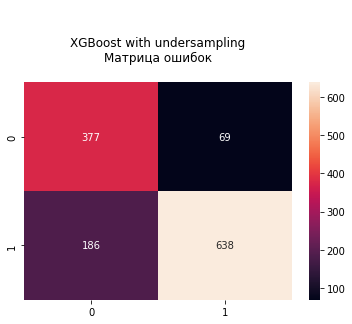

In [111]:
cm = confusion_matrix(y_val_t, xgb_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nXGBoost with undersampling\nМатрица ошибок\n')

Text(0.5, 1, '\n\nXGBoost with oversampling\nМатрица ошибок\n')

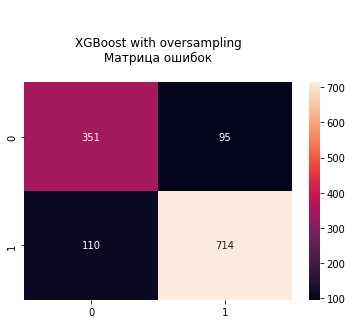

In [112]:
cm_ros = confusion_matrix(y_val_t, xgb_ros_pred)
sns.heatmap(cm_ros, annot=True, fmt='d').set_title('\n\nXGBoost with oversampling\nМатрица ошибок\n')

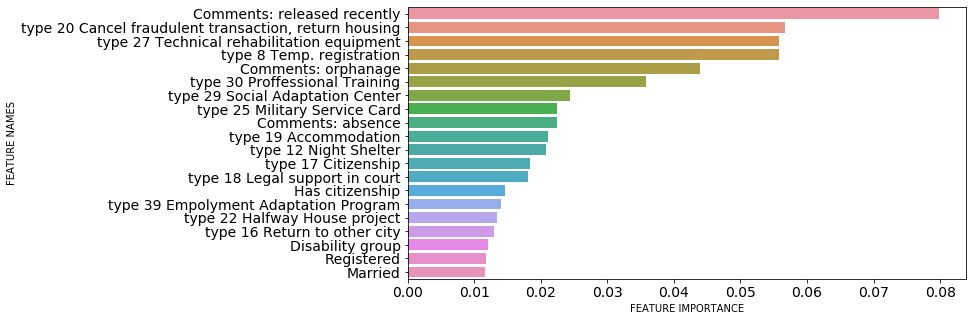

In [113]:
plot_feature_importance(xgb.feature_importances_, x_columns_t, 'XGBOOST undersampling ')

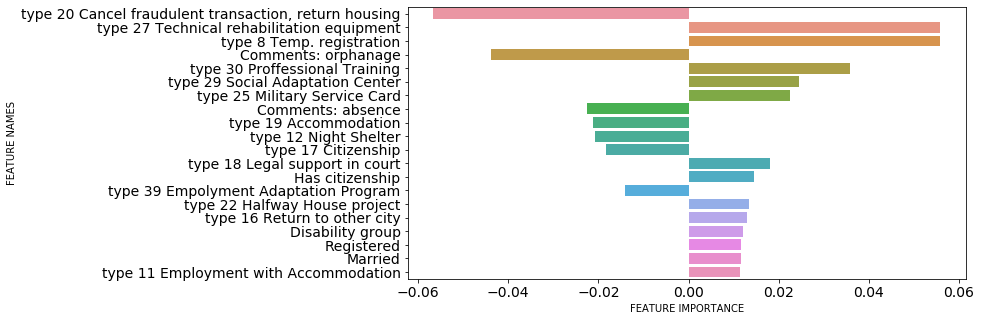

In [122]:
plot_icicle(xgb, x_columns_t, xgb.feature_importances_)

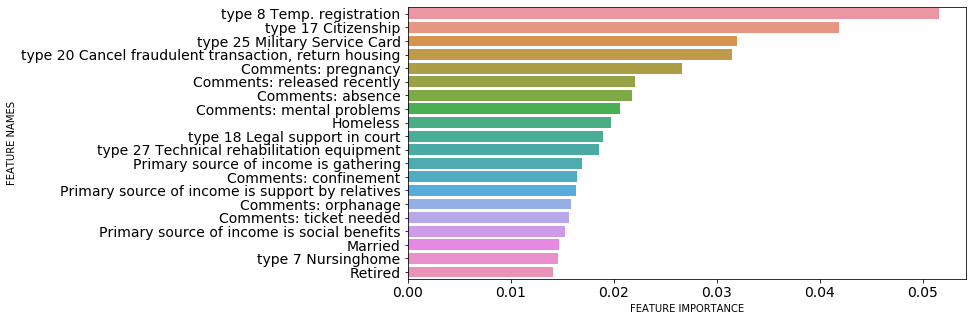

In [114]:
plot_feature_importance(xgb_ros.feature_importances_, x_columns_t, 'XGBOOST oversampling ')

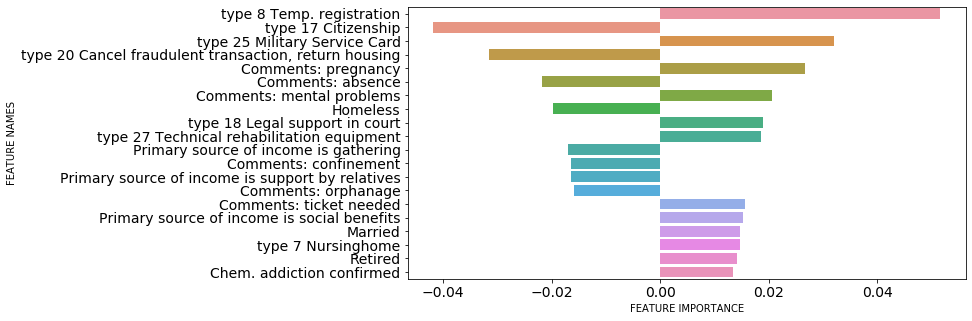

In [123]:
plot_icicle(xgb_ros, x_columns_t, xgb_ros.feature_importances_)

## CatBoost

### From file

In [ ]:
cb = CatBoostClassifier(random_state=SEED)
cb_ros = CatBoostClassifier(random_state=SEED)

In [ ]:
cb.load_model('cb.model')
cb_ros.load_model('cb_ros.model')

MSE = 0.2440944881889764
Accuracy = 0.7559055118110236
Precision = 0.7487864077669902
Recall = 0.8569444444444444
F1 Score = 0.7992227979274611
              precision    recall  f1-score   support

unsuccessful       0.62      0.77      0.69       446
  successful       0.86      0.75      0.80       824

    accuracy                           0.76      1270
   macro avg       0.74      0.76      0.74      1270
weighted avg       0.78      0.76      0.76      1270



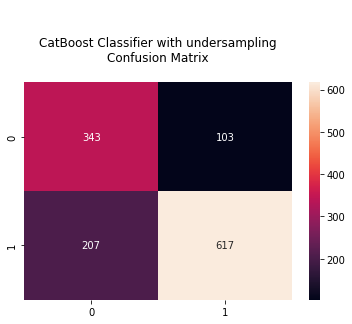

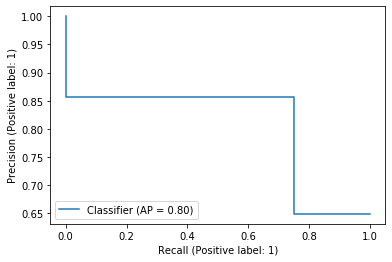

In [ ]:
cb_pred = cb.predict(X_val_t)
print('MSE =', mean_squared_error(cb_pred, y_val_t))
print('Accuracy =', accuracy_score(cb_pred, y_val_t))
print('Precision =', precision_score(cb_pred, y_val_t))
print('Recall =', recall_score(cb_pred, y_val_t))
print('F1 Score =', f1_score(cb_pred, y_val_t))

print(classification_report(y_val_t, cb_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, cb_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nCatBoost Classifier with undersampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, cb_pred)

MSE = 0.2440944881889764
Accuracy = 0.7559055118110236
Precision = 0.7487864077669902
Recall = 0.8569444444444444
F1 Score = 0.7992227979274611
              precision    recall  f1-score   support

unsuccessful       0.62      0.77      0.69       446
  successful       0.86      0.75      0.80       824

    accuracy                           0.76      1270
   macro avg       0.74      0.76      0.74      1270
weighted avg       0.78      0.76      0.76      1270



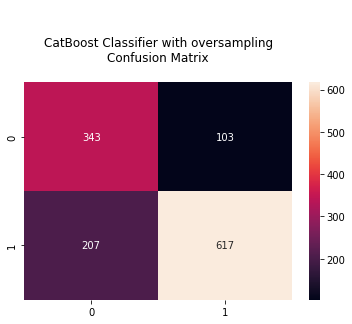

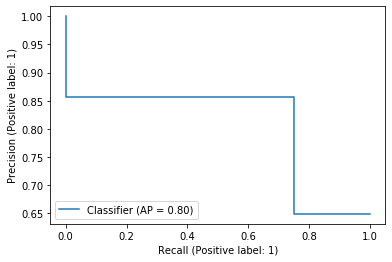

In [ ]:
cb_ros_pred = cb.predict(X_val_t)
print('MSE =', mean_squared_error(cb_ros_pred, y_val_t))
print('Accuracy =', accuracy_score(cb_ros_pred, y_val_t))
print('Precision =', precision_score(cb_ros_pred, y_val_t))
print('Recall =', recall_score(cb_ros_pred, y_val_t))
print('F1 Score =', f1_score(cb_ros_pred, y_val_t))

print(classification_report(y_val_t, cb_ros_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, cb_ros_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nCatBoost Classifier with oversampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, cb_ros_pred)

Results seem identical. Probably, the same file was saved under different names.

MSE = 0.2409448818897638
Accuracy = 0.7590551181102362
Precision = 0.7439320388349514
Recall = 0.865819209039548
F1 Score = 0.8002610966057441
              precision    recall  f1-score   support

unsuccessful       0.62      0.79      0.70       446
  successful       0.87      0.74      0.80       824

    accuracy                           0.76      1270
   macro avg       0.75      0.77      0.75      1270
weighted avg       0.78      0.76      0.76      1270



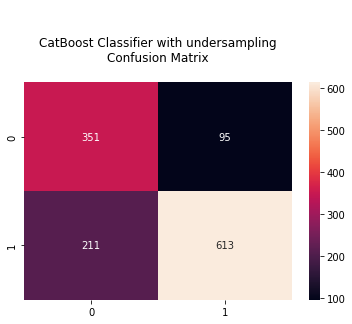

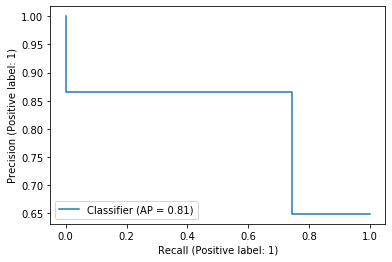

In [117]:
cb = CatBoostClassifier(random_state=SEED)
cb.fit(X_res_train_t, y_res_train_t, verbose=0)
cb_pred = cb.predict(X_val_t)
print('MSE =', mean_squared_error(cb_pred, y_val_t))
print('Accuracy =', accuracy_score(cb_pred, y_val_t))
print('Precision =', precision_score(cb_pred, y_val_t))
print('Recall =', recall_score(cb_pred, y_val_t))
print('F1 Score =', f1_score(cb_pred, y_val_t))

print(classification_report(y_val_t, cb_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, cb_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nCatBoost Classifier with undersampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, cb_pred)

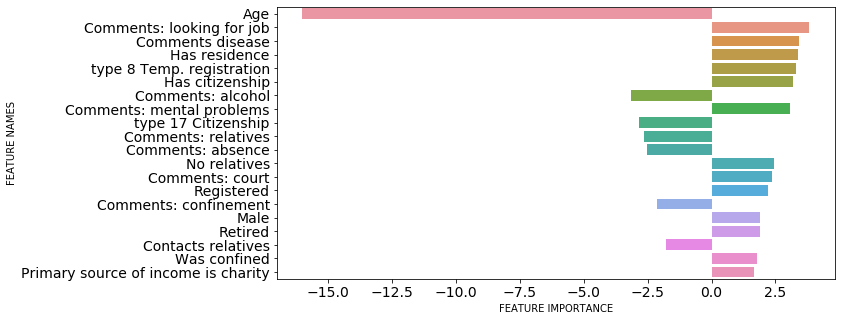

In [118]:
plot_icicle(cb, x_columns_t, cb.get_feature_importance())

MSE = 0.2409448818897638
Accuracy = 0.7590551181102362
Precision = 0.7439320388349514
Recall = 0.865819209039548
F1 Score = 0.8002610966057441
              precision    recall  f1-score   support

unsuccessful       0.62      0.79      0.70       446
  successful       0.87      0.74      0.80       824

    accuracy                           0.76      1270
   macro avg       0.75      0.77      0.75      1270
weighted avg       0.78      0.76      0.76      1270



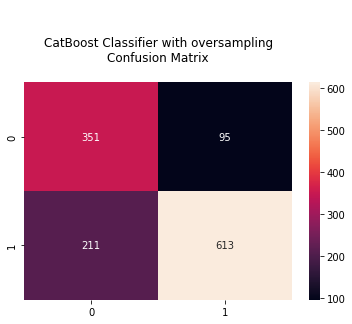

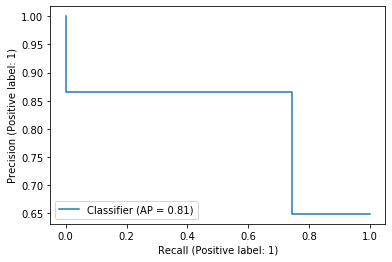

In [119]:
cb_ros = CatBoostClassifier(random_state=SEED)
cb_ros.fit(X_ros_train_t, y_ros_train_t, verbose=0)
cb_ros_pred = cb.predict(X_val_t)
print('MSE =', mean_squared_error(cb_ros_pred, y_val_t))
print('Accuracy =', accuracy_score(cb_ros_pred, y_val_t))
print('Precision =', precision_score(cb_ros_pred, y_val_t))
print('Recall =', recall_score(cb_ros_pred, y_val_t))
print('F1 Score =', f1_score(cb_ros_pred, y_val_t))

print(classification_report(y_val_t, cb_ros_pred, target_names=['unsuccessful', 'successful']))

cm = confusion_matrix(y_val_t, cb_ros_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('\n\nCatBoost Classifier with oversampling\nConfusion Matrix\n')

PrecisionRecallDisplay.from_predictions(y_val_t, cb_ros_pred)

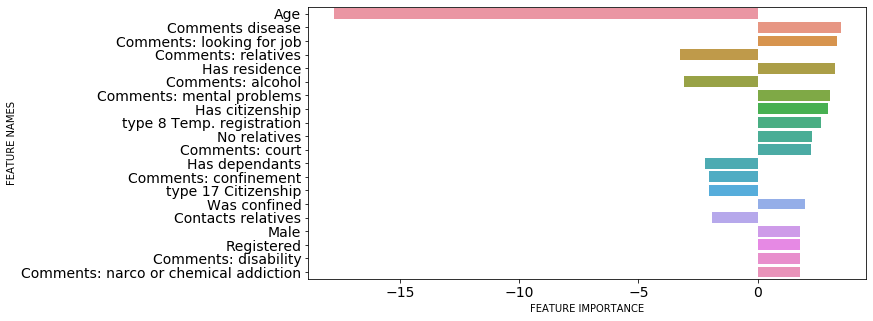

In [120]:
plot_icicle(cb_ros, x_columns_t, cb_ros.get_feature_importance())

## Typical client

### Client with no data (all NaNs)

In [124]:
no_client_t = pd.DataFrame(columns=x_columns_t)
no_client_t = no_client_t.astype(X_t.dtypes.to_dict())
no_client_t = no_client_t.append(pd.Series(), ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#no_client_t.to_csv('no_client.csv', index=False)

In [ ]:
#no_client_t = pd.read_csv('no_client.csv')

### Client with averaged data (with NaNs)

Seems like only age can be averaged, the rest needs to be replaced with the most frequent value.

In [138]:
typical_client_t = no_client_t.copy()
typical_client_t.age = with_onehot_types.age.mean()
typical_client_t.age

0    50.410812
Name: age, dtype: float64

In [139]:
ones = []
zeros = []
for column in X_t.columns:
    if column != 'age' and column != 'disability_group' and column != 'released_recently' and not column.startswith('type_'):
        if X_t[column].value_counts()[0] == max(X_t[column].value_counts()[0], X_t[column].value_counts()[1], X_t.shape[0] - X_t[column].value_counts()[0] - X_t[column].value_counts()[1]):
            zeros.append(column)
        elif X_t[column].value_counts()[1] == max(X_t[column].value_counts()[0], X_t[column].value_counts()[1], X_t.shape[0] - X_t[column].value_counts()[0] - X_t[column].value_counts()[1]):
            ones.append(column)
ones

['is_homeless', 'gender']

In [140]:
zeros

['comments_noresidence',
 'is_married',
 'comments_disease',
 'comments_work',
 'comments_relatives',
 'comments_disability',
 'no_birthdate',
 'comments_aggression',
 'comments_mental',
 'comments_confinement',
 'comments_ticket',
 'contacts_relatives',
 'comments_divorce',
 'comments_fire',
 'comments_social_benefits',
 'comments_absence',
 'comments_illiteracy',
 'has_dependants',
 'comments_foreigner',
 'comments_chem',
 'comments_pregnancy',
 'comments_alcohol',
 'no_relatives',
 'comments_death',
 'has_residence',
 'comments_orphange',
 'comments_disturbance',
 'comments_nursinghome',
 'comments_court']

In [141]:
typical_client_t[ones] = 1
typical_client_t[zeros] = 0

In [ ]:
#typical_client_t.to_csv('typical_client.csv', index=False)

In [ ]:
#typical_client_t = pd.read_csv('typical_client_with_nans.csv')

Contract types are NaNs here, which is not in line with the dataset logic. Better set them all to zeros.

In [145]:
typical_client_t.type_17

0    0
Name: type_17, dtype: int64

In [143]:
types = [c for c in X_t.columns if c.startswith('type_')]
len(types)

43

In [144]:
typical_client_t[types] = 0

In [ ]:
# typical_client_t.to_csv("typical_client_with_nans.csv", index = False)

### Typical client without NaNs (to evaluate models that don't eat NaNs)

In [146]:
typical_client_nonans = typical_client_t.fillna(0)
typical_client_nonans.isna().any().sum()

0

In [ ]:
# typical_client_nonans.to_csv("typical_client_without_nans.csv", index=False)